In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##Defining material properties :

In [2]:
k = 0.47        # Thermal conductivity (W/m.K)
rho = 1573      # Density (kg/m^3)
Cp = 967        # Specific heat capacity (J/kg.K)
alpha = k / (rho * Cp)  # Thermal diffusivity (m^2/s)

# Problem geometry and boundary conditions
L = 0.01        # Thickness of the material (m)
T_inf = 50      # Ambient air temperature (°C)
T0 = 0          # Initial temperature (°C)
h_top = 100     # Heat transfer coefficient on the top surface (W/m²K)
h_bottom = 50   # Heat transfer coefficient on the bottom surface (W/m²K)

##Generating datapoints :

In [3]:
x_points = 100  # Number of points along the x-axis
t_points = 100  # Number of points along the time-axis
x = np.linspace(0, L, x_points)  # Position
t = np.linspace(0, 600, t_points)  # Time

X, T = np.meshgrid(x, t)
train_x = tf.convert_to_tensor(X.flatten().reshape(-1, 1), dtype=tf.float32)
train_t = tf.convert_to_tensor(T.flatten().reshape(-1, 1), dtype=tf.float32)

train_data = tf.concat([train_x, train_t], axis=1)

##Building the Physics-Informed NN Class and Loss Function:

In [4]:
#Let's define the PINN Class
class PINN(tf.keras.Model):
    """
    Physics-Informed Neural Network (PINN) to approximate the solution of a PDE.
    This class defines a fully connected feedforward neural network with a physics-informed loss function.
    """
    def __init__(self, layers, activation='tanh'):
        """
        Initialize the PINN model with the given architecture.

        Args:
            layers (list): List specifying the number of neurons in each layer, e.g., [2, 32, 32, 1].
            activation (str): Activation function for the hidden layers (default is 'tanh').
        """
        super().__init__()

        # Input validation
        if len(layers) < 2:
            raise ValueError("The 'layers' argument must have at least two elements (input and output layers).")

        self.activation = activation
        self.network = self.build_network(layers)

    def build_network(self, layers):
        """
        Create a sequential feedforward neural network.

        Args:
            layers (list): Architecture of the network.

        Returns:
            tf.keras.Sequential: The constructed network.
        """
        model = tf.keras.Sequential()

        for i in range(len(layers) - 1):
            units = layers[i + 1]
            if i < len(layers) - 2:
                model.add(tf.keras.layers.Dense(units, activation=self.activation))
            else:
                model.add(tf.keras.layers.Dense(units))  # Output layer has no activation

        return model

    def call(self, inputs):
        """
        Perform a forward pass through the network.

        Args:
            inputs (Tensor): Input tensor (e.g., containing spatial and temporal variables like x and t).

        Returns:
            Tensor: The output tensor (e.g., predicted solution T(x, t)).
        """
        return self.network(inputs)

In [5]:
def loss_fn(model, x, t):
    """
    Loss function for the PINN including PDE residual, boundary conditions, and initial conditions.
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        inputs = tf.concat([x, t], axis=1)
        u = model(inputs)

        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)

    u_xx = tape.gradient(u_x, x)
    del tape

    # Physics-informed loss: Residual of the PDE (du/dt = alpha * d²u/dx²)
    pde_loss = tf.reduce_mean(tf.square(u_t - alpha * u_xx))

    # Boundary condition loss (convective heat transfer)
    bc_top = tf.reduce_mean(tf.square(h_top * (T_inf - u) - k * u_x))  # At x = 0
    bc_bottom = tf.reduce_mean(tf.square(h_bottom * (T_inf - u) - k * u_x))  # At x = L

    # Initial condition loss (u(x, t=0) = T0)
    ic_loss = tf.reduce_mean(tf.square(u - T0))

    total_loss = pde_loss + bc_top + bc_bottom + ic_loss
    return total_loss

pinn_layers = [2, 64,64, 32, 1]
pinn = PINN(layers=pinn_layers, activation='tanh')

## Training our model :

In [6]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
epochs = 5000
print_interval = 100
loss_history = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(pinn, train_x, train_t)
    gradients = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

    loss_history.append(loss.numpy())
    if epoch % print_interval == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy():.6f}")

Epoch 0: Loss = 32524152.000000
Epoch 100: Loss = 18952786.000000
Epoch 200: Loss = 15832637.000000
Epoch 300: Loss = 13240627.000000
Epoch 400: Loss = 11031986.000000
Epoch 500: Loss = 9143882.000000
Epoch 600: Loss = 7533078.000000
Epoch 700: Loss = 6164474.000000
Epoch 800: Loss = 5007883.000000
Epoch 900: Loss = 4036508.250000
Epoch 1000: Loss = 3226321.250000
Epoch 1100: Loss = 2555742.500000
Epoch 1200: Loss = 2005325.875000
Epoch 1300: Loss = 1557626.500000
Epoch 1400: Loss = 1196995.750000
Epoch 1500: Loss = 909539.062500
Epoch 1600: Loss = 682963.625000
Epoch 1700: Loss = 506500.718750
Epoch 1800: Loss = 370804.937500
Epoch 1900: Loss = 267861.812500
Epoch 2000: Loss = 190870.859375
Epoch 2100: Loss = 134153.140625
Epoch 2200: Loss = 93026.250000
Epoch 2300: Loss = 63696.988281
Epoch 2400: Loss = 43141.996094
Epoch 2500: Loss = 28996.226562
Epoch 2600: Loss = 19444.472656
Epoch 2700: Loss = 13121.015625
Epoch 2800: Loss = 9019.943359
Epoch 2900: Loss = 6416.575195
Epoch 3000: 

###After running for 5000 epochs it roughly converged to loss=2499.

## Loss as a function of number of epochs

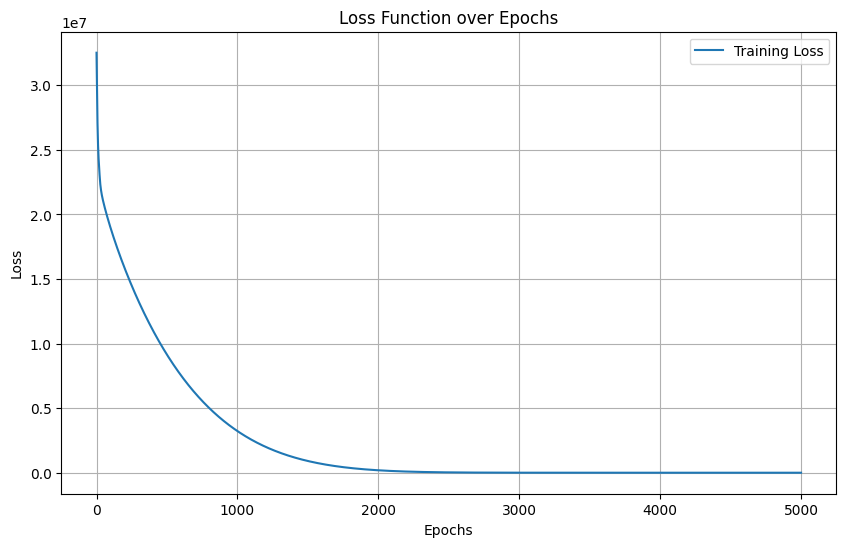

In [7]:
#Plotting the loss over number of epochs.
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), loss_history, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Function over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## Generating a test dataset to test model

In [8]:
# Test the model with new data
x_test = np.linspace(0, L, x_points).reshape(-1, 1)
t_test = np.linspace(0, 600, t_points).reshape(-1, 1)
X_test, T_test = np.meshgrid(x_test, t_test)
test_data = tf.convert_to_tensor(np.hstack((X_test.flatten().reshape(-1, 1), T_test.flatten().reshape(-1, 1))), dtype=tf.float32)

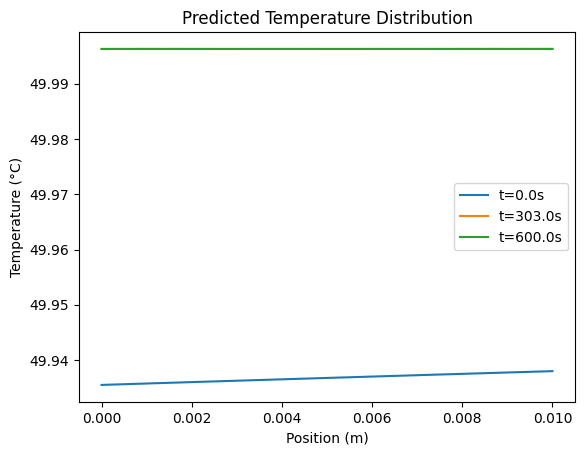

In [ ]:
# Predict temperature values
predictions = pinn(test_data)
predicted_temperatures = tf.reshape(predictions, X_test.shape).numpy()

# Plot temperature profiles at different time points
time_indices = [0, 50, 99]
for idx in time_indices:
    plt.plot(x_test, predicted_temperatures[idx, :], label=f"t={t_test[idx, 0]:.1f}s")
plt.xlabel("Position (m)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Predicted Temperature Distribution in degrees celsius")
plt.show()